# Looped Transformers for Length Generalization
This notebook compares looped transformers to simple ones and shows how they can generalize out of distribution to with addition.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [2]:
# ==========================================
# 1. DATA GENERATION
# ==========================================
def generate_batch(batch_size, bits):
    X, Y = [], []
    for _ in range(batch_size):
        a = random.randint(0, 2**bits - 1)
        b = random.randint(0, 2**bits - 1)
        c = a + b
        
        a_bin = [int(x) for x in format(a, f'0{bits}b')[::-1]]
        b_bin = [int(x) for x in format(b, f'0{bits}b')[::-1]]
        c_bin = [int(x) for x in format(c, f'0{bits}b')[::-1]]
        
        # Handle overflow/padding
        if len(c_bin) < bits: 
            c_bin += [0] * (bits - len(c_bin))
        c_bin = c_bin[:bits]
        
        x_seq = [[a_val, b_val] for a_val, b_val in zip(a_bin, b_bin)]
        X.append(x_seq)
        Y.append(c_bin)
        
    return torch.tensor(X).float().to(device), torch.tensor(Y).long().to(device)

# Example usage:
X_example, Y_example = generate_batch(2, bits=8)
print("Example Input (X):", X_example)
print("Example Output (Y):", Y_example)

Example Input (X): tensor([[[0., 1.],
         [0., 0.],
         [1., 1.],
         [0., 0.],
         [0., 1.],
         [1., 1.],
         [0., 1.],
         [0., 0.]],

        [[0., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 0.],
         [1., 0.],
         [0., 0.]]], device='cuda:0')
Example Output (Y): tensor([[1, 0, 0, 1, 1, 0, 0, 1],
        [0, 1, 1, 1, 1, 0, 1, 0]], device='cuda:0')


In [ ]:
# ==========================================
# 2. STANDARD TRANSFORMER (Baseline)
# ==========================================
class StandardTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers=4, max_len=100):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Absolute Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model) * 0.1)
        
        
        # Transformer Encoder Block
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_head = nn.Linear(d_model, 2) # MLP that outputs 2 classes (0 or 1)

    def forward(self, x, num_loops=None):
        seq_len = x.shape[1]
        # Add absolute position (up to current length)
        # If seq_len > max_len, this crashes or requires slicing (we slice here)
        pos = self.pos_embedding[:, :seq_len, :]
        x = self.embedding(x) + pos
        x = self.transformer(x)
        return self.output_head(x)

# ==========================================
# 3. LOOPED TRANSFORMER
# ==========================================
class LoopedTransformerRelative(nn.Module):
    def __init__(self, input_dim, d_model, nhead, max_relative_dist=4):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Learned Relative Bias Table
        self.max_relative_dist = max_relative_dist
        # Range [-dist, +dist] -> size is 2*dist + 1
        self.relative_bias_table = nn.Parameter(torch.Tensor(1, nhead, 2 * max_relative_dist + 1))
        nn.init.xavier_uniform_(self.relative_bias_table)
        
        self.shared_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4, batch_first=True, norm_first=True
        )
        self.output_head = nn.Linear(d_model, 2)
        self.input_gate = nn.Parameter(torch.tensor(0.1))

    def get_relative_bias(self, seq_len, device):
        range_vec = torch.arange(seq_len, device=device)
        distance_mat = range_vec[None, :] - range_vec[:, None]
        
        # CRITICAL: Clamp distance to Trained Window (e.g., -4 to 4)
        distance_mat_clamped = torch.clamp(distance_mat, -self.max_relative_dist, self.max_relative_dist)
        final_indices = distance_mat_clamped + self.max_relative_dist
        
        bias = self.relative_bias_table[0, :, final_indices.long()] # [nhead, L, L]
        
        # Causal Mask (Prevent cheating by looking ahead)
        causal_mask = torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=device), diagonal=1)
        return bias + causal_mask.unsqueeze(0)

    def forward(self, x, num_loops=None):
        B, seq_len, _ = x.shape
        # Adaptive Depth: If input is longer, think longer.
        if num_loops is None:
            num_loops = seq_len + 5 

        input_emb = self.embedding(x)
        h = input_emb.clone()
        
        # Get Bias
        relative_bias = self.get_relative_bias(seq_len, x.device)
        attn_mask = relative_bias.repeat(B, 1, 1) # Repeat for batch

        for _ in range(num_loops):
            h_new = self.shared_layer(h, src_mask=attn_mask)
            # Input Injection (Skip Connection to Input)
            h = h_new + (self.input_gate * input_emb)
            
        return self.output_head(h)

In [ ]:
# ==========================================
# 4. EXPERIMENT RUNNER
# ==========================================
def train_model(model_class, name, kwargs):
    print(f"\n--- Training {name} ---")
    model = model_class(**kwargs).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Train on 8-bit ONLY
    for step in range(2501):
        optimizer.zero_grad()
        # t = torch.randint(0, 4, (1,)).item()
        X, Y = generate_batch(64, bits=8)
        
        # Use 12 loops for training (8 bits + buffer)
        # Standard model ignores this argument
        output = model(X, num_loops=12) 
        
        loss = criterion(output.reshape(-1, 2), Y.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if step % 500 == 0:
            acc = (output.argmax(-1) == Y).float().mean()
            print(f"Step {step}: Loss {loss.item():.4f}, Train Acc (8-bit): {acc:.2f}")
            
    return model

def evaluate_length_generalization(model, name, test_lengths):
    accuracies = []
    print(f"Evaluating {name}...", end=" ")
    for L in test_lengths:
        with torch.no_grad():
            X, Y = generate_batch(100, bits=L)
            # Dynamic Loops: Scale loops with problem length L
            # Standard model will ignore this and use fixed layers
            output = model(X, num_loops=L + 5) 
            acc = (output.argmax(-1) == Y).float().mean().item()
            accuracies.append(acc)
    print("Done.")
    return accuracies


--- Training Standard Transformer ---
Step 0: Loss 1.4052, Train Acc (8-bit): 0.50


c:\Users\Ous\miniconda3\envs\ML\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Step 500: Loss 0.0078, Train Acc (8-bit): 1.00
Step 1000: Loss 0.0083, Train Acc (8-bit): 1.00
Step 1500: Loss 0.0053, Train Acc (8-bit): 1.00
Step 2000: Loss 0.0135, Train Acc (8-bit): 1.00
Step 2500: Loss 0.0020, Train Acc (8-bit): 1.00

--- Training Looped Transformer ---
Step 0: Loss 0.8335, Train Acc (8-bit): 0.53
Step 500: Loss 0.0024, Train Acc (8-bit): 1.00
Step 1000: Loss 0.0025, Train Acc (8-bit): 1.00
Step 1500: Loss 0.0026, Train Acc (8-bit): 1.00
Step 2000: Loss 0.0001, Train Acc (8-bit): 1.00
Step 2500: Loss 0.0002, Train Acc (8-bit): 1.00
Evaluating Standard... Done.
Evaluating Looped... Done.

Results:
Lengths: [8, 12, 16, 20, 24, 32, 40, 48]
Standard Acc: [1.0, 0.9483333826065063, 0.8449999690055847, 0.7780000567436218, 0.7320833802223206, 0.6875, 0.6472500562667847, 0.62479168176651]
Looped Acc:   [1.0, 1.0, 1.0, 0.9985000491142273, 0.9945833683013916, 0.9881249666213989, 0.9772500395774841, 0.9585416913032532]


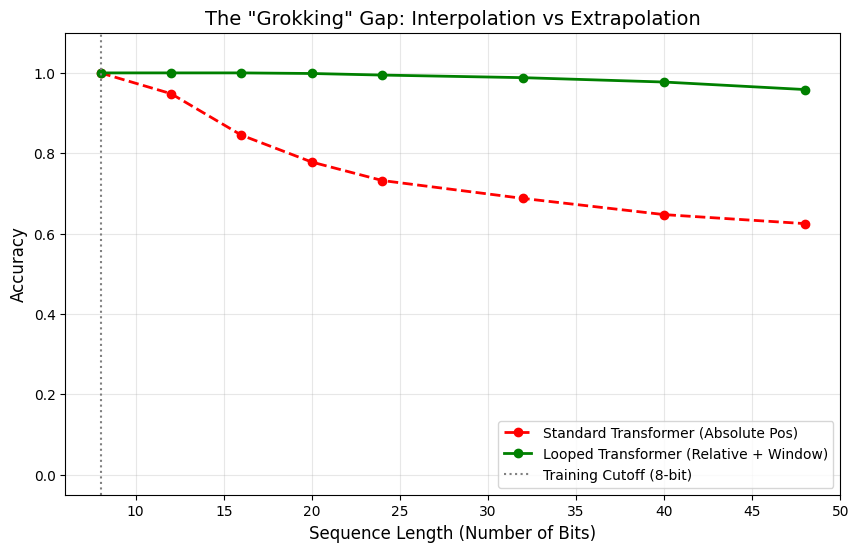

In [7]:

# ==========================================
# 5. EXECUTION & PLOTTING
# ==========================================

# Parameters
D_MODEL = 64
NHEAD = 4
INPUT_DIM = 2

# 1. Train Standard (Fixed Depth = 4 Layers, Absolute Pos)
std_model = train_model(
    StandardTransformer, 
    "Standard Transformer", 
    {"input_dim": INPUT_DIM, "d_model": D_MODEL, "nhead": NHEAD, "num_layers": 4}
)

# 2. Train Looped (Relative Pos, Window=4)
# Note: max_relative_dist=4 ensures we cover the window within 8-bit training
looped_model = train_model(
    LoopedTransformerRelative, 
    "Looped Transformer", 
    {"input_dim": INPUT_DIM, "d_model": D_MODEL, "nhead": NHEAD, "max_relative_dist": 4}
)

# 3. Test Generalization (From 8 bits up to 48 bits)
test_lengths = [8, 12, 16, 20, 24, 32, 40, 48]
std_acc = evaluate_length_generalization(std_model, "Standard", test_lengths)
loop_acc = evaluate_length_generalization(looped_model, "Looped", test_lengths)

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(test_lengths, std_acc, 'o--', label='Standard Transformer (Absolute Pos)', color='red', linewidth=2)
plt.plot(test_lengths, loop_acc, 'o-', label='Looped Transformer (Relative + Window)', color='green', linewidth=2)

# Formatting
plt.axvline(x=8, color='gray', linestyle=':', label='Training Cutoff (8-bit)')
plt.title('The "Grokking" Gap: Interpolation vs Extrapolation', fontsize=14)
plt.xlabel('Sequence Length (Number of Bits)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(-0.05, 1.1)
plt.grid(True, alpha=0.3)
plt.legend()

# Show or Save
print("\nResults:")
print(f"Lengths: {test_lengths}")
print(f"Standard Acc: {std_acc}")
print(f"Looped Acc:   {loop_acc}")

plt.show() # If running in notebook
# plt.savefig("generalization_plot.png") # If running in script